In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch_harmonics as th
from torch_harmonics.random_fields import GaussianRandomFieldS2

from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [2]:
dtrain = np.load('../data/era5_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

def clim_smooth(data, kernel):
    return jax.scipy.signal.convolve2d(data, kernel, mode='same')
clim_smooth = jit(vmap(clim_smooth, (0, None)))

kernel = jnp.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]])
kernel = kernel / jnp.sum(kernel)
dtrain = np.array(clim_smooth(dtrain, kernel))

In [3]:
lag, lead = 1, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
xtrain = np.moveaxis(xtrain, 1, 3)
ytrain = np.moveaxis(ytrain, 1, 3)
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [19]:
nlat, nlon = xtrain.shape[1:3]

In [5]:
epochs = 50
trace = []
lag, lead = 1, 1

width = 50
drop_prob = 0.1

rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

base_model = DeepANO(lag, width, lead, rngs=model_rng)
base_optim = nnx.Optimizer(base_model, optax.adam(1e-3))
base_trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        base_loss = train_step(base_model, base_optim, xt, yt)
        base_trace.append(base_loss)

quant_model = DeepANO(lag, width, lead, rngs=model_rng)
quant_optim = nnx.Optimizer(quant_model, optax.adam(1e-3))
quant_trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        quant_loss = quant_step(quant_model, quant_optim, xt, yt)
        quant_trace.append(quant_loss)
        
prob_model = ProbANO(lag, width, lead, rngs=model_rng)
prob_optim = nnx.Optimizer(prob_model, optax.adam(1e-4))
prob_trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        prob_loss = prob_step(prob_model, prob_optim, xt, yt)
        prob_trace.append(prob_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
# epochs = 50
# trace = []
# lag, lead = 1, 1

# width = 50
# drop_prob = 0.1

# rng = random.PRNGKey(0)
# model_rng = nnx.Rngs(1)
# base_model = DeepANO(lag, width, lead, rngs=model_rng)
# # drop_model = DropANO(lag, width, lead, drop_prob, rngs=model_rng)
# prob_model = ProbANO(lag, width, lead, rngs=model_rng)
# quant_model = DeepANO(lag, width, lead, rngs=model_rng)

# base_optim = nnx.Optimizer(base_model, optax.adam(1e-3))
# # drop_optim = nnx.Optimizer(drop_model, optax.adam(1e-3))
# prob_optim = nnx.Optimizer(prob_model, optax.adam(1e-4))
# quant_optim = nnx.Optimizer(quant_model, optax.adam(1e-3))

# base_trace = []
# prob_trace = []
# quant_trace = []

# for _ in trange(epochs):
#     for xt, yt in train_loader:
#         xt = torch2jax(xt)
#         yt = torch2jax(yt)
        
#         base_loss = train_step(base_model, base_optim, xt, yt)
#         # drop_loss = train_step(drop_model, drop_optim, xt, yt)
#         prob_loss = prob_step(prob_model, prob_optim, xt, yt)
#         quant_loss = quant_step(quant_model, quant_optim, xt, yt)

#         base_trace.append(base_loss)
#         prob_trace.append(prob_loss)
#         quant_trace.append(quant_loss)

In [7]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')
dtest_ood = np.load('../data/era5_test_ood_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)
dtest_ood = np.mean(dtest_ood.reshape(-1, 4, nlat, nlon), axis = 1)

dval = np.array(clim_smooth(dval, kernel))
dtest = np.array(clim_smooth(dtest, kernel))
dtest_ood = np.array(clim_smooth(dtest_ood, kernel))

xval, yval = split_data(dval, lag, lead)
xtest, ytest = split_data(dtest, lag, lead)
xtest_ood, ytest_ood = split_data(dtest_ood, lag, lead)

xval = np.moveaxis(xval, 1, 3)
yval = np.moveaxis(yval, 1, 3)
xtest = np.moveaxis(xtest, 1, 3)
ytest = np.moveaxis(ytest, 1, 3)
xtest_ood = np.moveaxis(xtest_ood, 1, 3)
ytest_ood = np.moveaxis(ytest_ood, 1, 3)

val_data = TensorDataset(torch.Tensor(xval), torch.Tensor(yval))
test_data = TensorDataset(torch.Tensor(xtest), torch.Tensor(ytest))
test_ood_data = TensorDataset(torch.Tensor(xtest_ood), torch.Tensor(ytest_ood))
val_loader = DataLoader(val_data, batch_size = 100)
test_loader = DataLoader(test_data, batch_size = 100)
test_ood_loader = DataLoader(test_ood_data, batch_size = 100)

In [8]:
# yval_hat = base_model(xval)
# ytest_hat = base_model(xtest)

# yval_quant = quant_model(xval)
# ytest_quant = quant_model(xtest)

# yval_mu, yval_sd = prob_model(xval)
# ytest_mu, ytest_sd = prob_model(xtest)

In [9]:
yval_hat = []
yval_quant = []
yval_mu, yval_sd = [], []

ytest_hat = []
ytest_quant = []
ytest_mu, ytest_sd = [], []

ytest_ood_hat = []
ytest_ood_quant = []
ytest_ood_mu, ytest_ood_sd = [], []


for xt, _ in tqdm(val_loader, leave = False):
    xt = torch2jax(xt)
    yval_hat.append(base_model(xt))
    yval_quant.append(quant_model(xt))
    
    mu_t, sd_t = prob_model(xt)
    yval_mu.append(mu_t)
    yval_sd.append(sd_t)
    
for xt, _ in tqdm(test_loader, leave = False):
    xt = torch2jax(xt)
    ytest_hat.append(base_model(xt))
    ytest_quant.append(quant_model(xt))

    mu_t, sd_t = prob_model(xt)
    ytest_mu.append(mu_t)
    ytest_sd.append(sd_t)

for xt, _ in tqdm(test_ood_loader, leave = False):
    xt = torch2jax(xt)
    ytest_ood_hat.append(base_model(xt))
    ytest_ood_quant.append(quant_model(xt))

    mu_t, sd_t = prob_model(xt)
    ytest_ood_mu.append(mu_t)
    ytest_ood_sd.append(sd_t)

yval_hat = jnp.concat(yval_hat, axis = 0)
ytest_hat = jnp.concat(ytest_hat, axis = 0)
ytest_ood_hat = jnp.concat(ytest_ood_hat, axis = 0)

yval_quant = jnp.concat(yval_quant, axis = 0)
ytest_quant = jnp.concat(ytest_quant, axis = 0)
ytest_ood_quant = jnp.concat(ytest_ood_quant, axis = 0)

yval_mu = jnp.concat(yval_mu, axis = 0)
yval_sd = jnp.concat(yval_sd, axis = 0)
ytest_mu = jnp.concat(ytest_mu, axis = 0)
ytest_sd = jnp.concat(ytest_sd, axis = 0)
ytest_ood_mu = jnp.concat(ytest_ood_mu, axis = 0)
ytest_ood_sd = jnp.concat(ytest_ood_sd, axis = 0)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
nval = yval.shape[0]
ntest = ytest.shape[0]

In [11]:
yval = yval.reshape(nval, -1)
ytest = ytest.reshape(ntest, -1)
ytest_ood = ytest_ood.reshape(ntest, -1)

yval_hat = yval_hat.reshape(nval, -1)
ytest_hat = ytest_hat.reshape(ntest, -1)
ytest_ood_hat = ytest_ood_hat.reshape(ntest, -1)

yval_quant = yval_quant.reshape(nval, -1)
ytest_quant = ytest_quant.reshape(ntest, -1)
ytest_ood_quant = ytest_ood_quant.reshape(ntest, -1)

yval_mu = yval_mu.reshape(nval, -1)
yval_sd = yval_sd.reshape(nval, -1)
ytest_mu = ytest_mu.reshape(ntest, -1)
ytest_sd = ytest_sd.reshape(ntest, -1)
ytest_ood_mu = ytest_ood_mu.reshape(ntest, -1)
ytest_ood_sd = ytest_ood_sd.reshape(ntest, -1)

### Examples

In [147]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = matplotlib.colormaps.get_cmap('Reds').resampled(1)
bottom = matplotlib.colormaps['binary_r'].resampled(1)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='error')

In [163]:
nproj = npc = 200
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

rval = (yval - yval_hat).reshape(nval, -1)
rtest = (ytest - ytest_hat).reshape(ntest, -1)

state = lsci.lsci_state(xval.reshape(nval, -1), rval, npc)
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

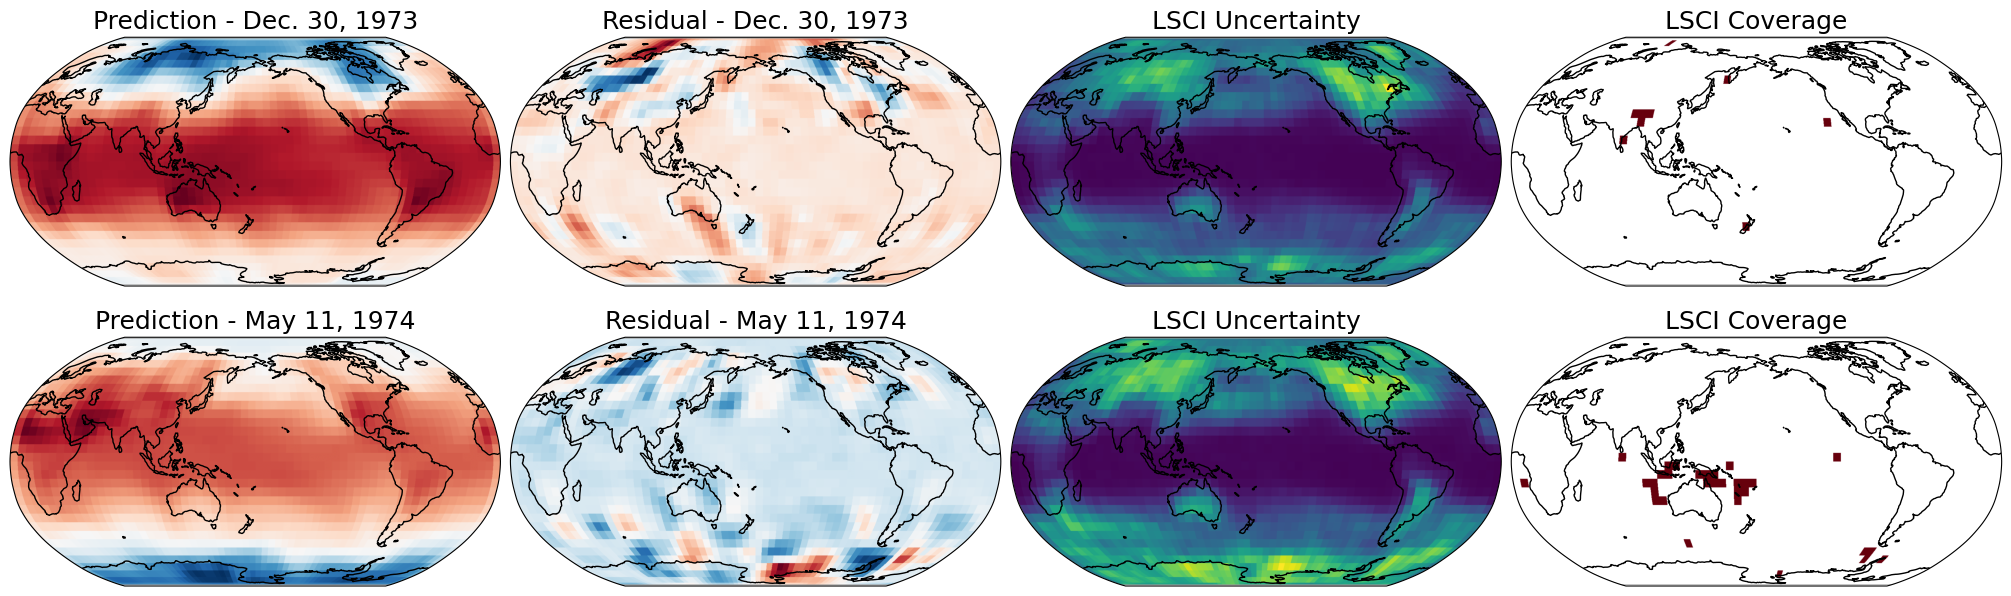

In [206]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

# dates = ['Jan 1st, 1959', 'Jan 2nd, 1959', 'Jan 3rd, 1959']
titles1 = [
    'Prediction - Dec. 30, 1973',
    'Residual - Dec. 30, 1973',
    'LSCI Uncertainty',
    'LSCI Coverage',
]
titles2 = [
    'Prediction - May 11, 1974',
    'Residual - May 11, 1974',
    'LSCI Uncertainty',
    'LSCI Coverage',
]
colors = ['RdBu_r', 'RdBu_r', 'viridis', newcmp]


fig = plt.figure(constrained_layout = True, figsize = (20, 6))
gs = GridSpec(2, 4, width_ratios = [1, 1, 1, 1], figure = fig)

ex1 = 10
ex2 = 10 + 12 * 11 * 4
xtest_i = xtest[ex1].reshape(1, -1)
ytest_i = ytest[ex1].reshape(1, -1)
rtest_i = rtest[ex1].reshape(1, -1)
ytest_hat_i = ytest_hat[ex1].reshape(1, -1)

lsci_lower, lsci_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma2)
cover_i = 1.0*((lsci_lower < rtest_i) * (lsci_upper > rtest_i)).reshape(nlat, nlon)

figs = [
    ytest_hat_i.reshape(nlat, nlon), 
    rtest_i.reshape(nlat, nlon),
    lsci_upper.reshape(nlat, nlon) - lsci_lower.reshape(nlat, nlon),
    cover_i
]

for k in range(len(figs)):
    ax = plt.subplot(gs[0,k], projection = plot_crs)
    im = ax.imshow(figs[k], cmap = colors[k], transform = data_crs)
    ax.coastlines()
    ax.set_title(titles1[k], fontsize = 18)

xtest_i = xtest[ex2].reshape(1, -1)
ytest_i = ytest[ex2].reshape(1, -1)
rtest_i = rtest[ex2].reshape(1, -1)
ytest_hat_i = ytest_hat[ex2].reshape(1, -1)

lsci_lower, lsci_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma2)
cover_i = 1.0*((lsci_lower < rtest_i) * (lsci_upper > rtest_i)).reshape(nlat, nlon)

figs = [
    ytest_hat_i.reshape(nlat, nlon), 
    rtest_i.reshape(nlat, nlon),
    lsci_upper.reshape(nlat, nlon) - lsci_lower.reshape(nlat, nlon),
    cover_i
]

for k in range(len(figs)):
    ax = plt.subplot(gs[1,k], projection = plot_crs)
    im = ax.imshow(figs[k], cmap = colors[k], transform = data_crs)
    ax.coastlines()
    ax.set_title(titles2[k], fontsize = 18)
plt.show()

<Figure size 2000x600 with 0 Axes>

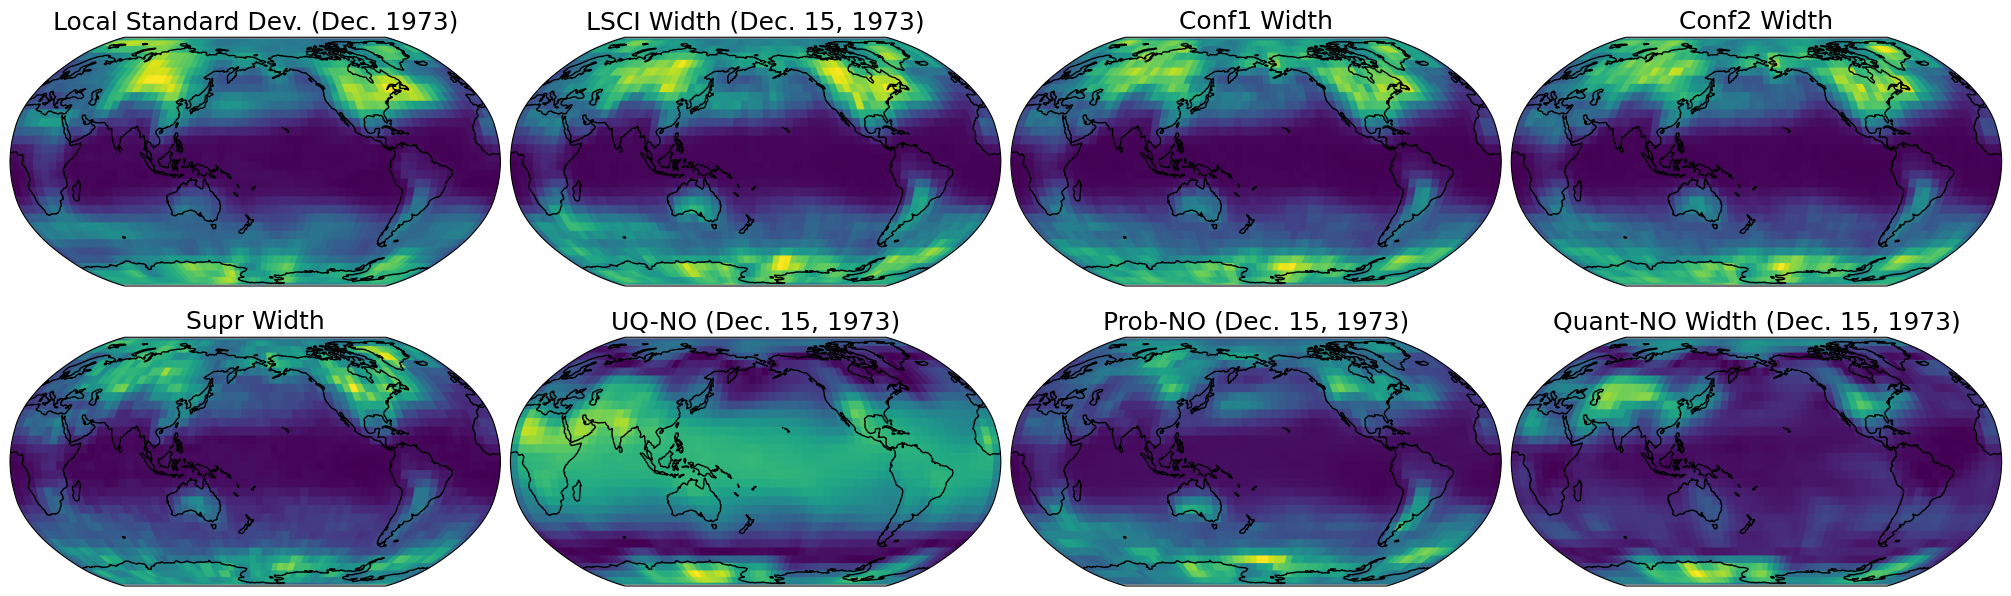

In [203]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

# dates = ['Jan 1st, 1959', 'Jan 2nd, 1959', 'Jan 3rd, 1959']
titles1 = [
    'Prediction - Dec. 30, 1973',
    'Residual - Dec. 30, 1973',
    'LSCI Uncertainty',
    'LSCI Coverage',
]
titles2 = [
    'Prediction - May 11, 1974',
    'Residual - May 11, 1974',
    'LSCI Uncertainty',
    'LSCI Coverage',
]
colors = ['RdBu_r', 'RdBu_r', 'viridis', newcmp]


fig = plt.figure(constrained_layout = True, figsize = (20, 6))
gs = GridSpec(2, 4, width_ratios = [1, 1, 1, 1], figure = fig)

ex1 = 100
xtest_i = xtest[ex1].reshape(1, -1)
ytest_i = ytest[ex1].reshape(1, -1)
rtest_i = rtest[ex1].reshape(1, -1)
ytest_hat_i = ytest_hat[ex1].reshape(1, -1)

lsci_lower, lsci_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma2)
conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

uqn1_lower, uqn1_upper = uqn1_upper[i], uqn1_lower[i]
pdon_lower, pdon_upper = pdon_upper[i], pdon_lower[i]
qdon_lower, qdon_upper = qdon_upper[i], qdon_lower[i]

uqn1_lower, uqn1_upper = np.min(np.vstack([uqn1_lower, uqn1_upper]), axis = 0), np.max(np.vstack([uqn1_lower, uqn1_upper]), axis = 0)
pdon_lower, pdon_upper = np.min(np.vstack([pdon_lower, pdon_upper]), axis = 0), np.max(np.vstack([pdon_lower, pdon_upper]), axis = 0)
qdon_lower, qdon_upper = np.min(np.vstack([qdon_lower, qdon_upper]), axis = 0), np.max(np.vstack([qdon_lower, qdon_upper]), axis = 0)

lsci_width = np.abs(lsci_upper - lsci_lower).reshape(nlat, nlon)
conf_width = np.abs(conf_upper - conf_lower).reshape(nlat, nlon)
gaus_width = np.abs(gaus_upper - gaus_lower).reshape(nlat, nlon)
supr_width = np.abs(supr_upper - supr_lower).reshape(nlat, nlon)
uqn1_width = np.abs(uqn1_upper - uqn1_lower).reshape(nlat, nlon)
pdon_width = np.abs(pdon_upper - pdon_lower).reshape(nlat, nlon)
qdon_width = np.abs(qdon_upper - qdon_lower).reshape(nlat, nlon)

row1 = [np.std(rtest[(ex1 - 4 * 15):(ex1 + 4 * 15)], axis = 0).reshape(nlat, nlon), lsci_width, conf_width, gaus_width]
row2 = [supr_width, uqn1_width, pdon_width, qdon_width]
titles1 = ['Local Standard Dev. (Dec. 1973)', 'LSCI Width (Dec. 15, 1973)', 'Conf1 Width', 'Conf2 Width']
titles2 = ['Supr Width', 'UQ-NO (Dec. 15, 1973)', 'Prob-NO (Dec. 15, 1973)', 'Quant-NO Width (Dec. 15, 1973)']

fig = plt.figure(constrained_layout = True, figsize = (20, 6))
gs = GridSpec(2, 4, width_ratios = [1, 1, 1, 1], figure = fig)

for k in range(4):
    ax = plt.subplot(gs[0, k], projection = plot_crs)
    im = ax.imshow(row1[k], transform = data_crs)
    ax.coastlines()
    ax.set_title(titles1[k], fontsize = 18)

for k in range(4):
    ax = plt.subplot(gs[1, k], projection = plot_crs)
    im = ax.imshow(row2[k], transform = data_crs)
    ax.coastlines()
    ax.set_title(titles2[k], fontsize = 18)
plt.show()

### In distribution errors

In [19]:
nproj = npc = 200
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).reshape(nval, -1)
rtest = (ytest - ytest_hat).reshape(ntest, -1)
rtest2 = (ytest - ytest_mu).reshape(ntest, -1)

state = lsci.lsci_state(xval.reshape(nval, -1), rval, npc)
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    xtest_i = xtest[i].reshape(1, -1)
    rtest_i = rtest[i].reshape(1, -1)
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest_i))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest_i))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest_i))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest_i))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest_i))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest_i))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest_i))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest_i))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest_i))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # # DROPOUT
    # drop_model.train()
    # drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    # drop_set = drop_set.reshape(500, -1)
    # drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    # drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    # drop_model.eval()
    
    # drop_risk.append(risk(drop_lower, drop_upper, rtest_i))
    # drop_width.append(jnp.median(drop_upper - drop_lower))

orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/1824 [00:00<?, ?it/s]

In [20]:
drop_risk, drop_width = jnp.zeros(ytest.shape[0]),  jnp.zeros(ytest.shape[0])

In [21]:
noise_sd = jnp.mean(rtest**2, axis = 1)

In [22]:
gamma = 0.95

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [23]:
methods = ['Oracle', 'MC-Drop', 'Conf1', 'Conf2', 
           'Supr', 'CQR-NO', 'Prob-NO', 'Quant-NO', 
           'LSCI1', 'LSCI2']

for i in range(metrics.shape[0]):
    print(f'{methods[i]} & ', end = '')
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

Oracle & 1.000 & 0.000 & 1.173 & 1.000 \\
MC-Drop & 0.000 & 0.000 & 0.000 & 0.000 \\
Conf1 & 0.990 & -0.209 & 10.377 & 0.000 \\
Conf2 & 0.987 & -0.209 & 10.386 & 0.000 \\
Supr & 1.000 & -0.423 & 12.388 & 0.000 \\
CQR-NO & 0.897 & -0.572 & 16.733 & 0.126 \\
Prob-NO & 0.025 & -0.051 & 5.112 & 0.175 \\
Quant-NO & 0.117 & -0.032 & 8.472 & 0.187 \\
LSCI1 & 0.962 & -0.323 & 8.876 & 0.182 \\
LSCI2 & 0.953 & -0.313 & 8.806 & 0.206 \\


In [25]:
metrics_in = metrics

### OOD errors

In [26]:
nproj = npc = 200
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).reshape(nval, -1)
rtest = (ytest_ood - ytest_ood_hat).reshape(ntest, -1)
rtest2 = (ytest_ood - ytest_ood_mu).reshape(ntest, -1)

state = lsci.lsci_state(xval.reshape(nval, -1), rval, npc)
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_ood_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest_ood, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest_ood, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    xtest_i = xtest_ood[i].reshape(1, -1)
    rtest_i = rtest[i].reshape(1, -1)
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest_i))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest_i))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest_i))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest_i))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest_i))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest_i))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest_i))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest_i))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest_i))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # # DROPOUT
    # drop_model.train()
    # drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    # drop_set = drop_set.reshape(500, -1)
    # drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    # drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    # drop_model.eval()
    
    # drop_risk.append(risk(drop_lower, drop_upper, rtest_i))
    # drop_width.append(jnp.median(drop_upper - drop_lower))

orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/1824 [00:00<?, ?it/s]

In [27]:
drop_risk, drop_width = jnp.zeros(ytest.shape[0]),  jnp.zeros(ytest.shape[0])

In [28]:
noise_sd = jnp.mean(rtest**2, axis = 1)

In [29]:
gamma = 0.95

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [30]:
methods = ['Oracle', 'MC-Drop', 'Conf1', 'Conf2', 
           'Supr', 'CQR-NO', 'Prob-NO', 'Quant-NO', 
           'LSCI1', 'LSCI2']

for i in range(metrics.shape[0]):
    print(f'{methods[i]} & ', end = '')
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

Oracle & 1.000 & 0.000 & 1.180 & 1.000 \\
MC-Drop & 0.000 & 0.000 & 0.000 & 0.000 \\
Conf1 & 0.995 & -0.208 & 10.377 & 0.000 \\
Conf2 & 0.994 & -0.212 & 10.386 & 0.000 \\
Supr & 1.000 & -0.323 & 12.388 & 0.000 \\
CQR-NO & 0.876 & -0.510 & 16.495 & 0.168 \\
Prob-NO & 0.002 & -0.061 & 4.057 & 0.207 \\
Quant-NO & 0.263 & -0.043 & 9.178 & 0.212 \\
LSCI1 & 0.967 & -0.341 & 8.780 & 0.238 \\
LSCI2 & 0.960 & -0.345 & 8.691 & 0.240 \\


In [31]:
metrics_out = metrics

In [30]:
nproj = nlat*nlon
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nsamp = 5000
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval + 1))/(gamma2*nval)

lsc1_rc = []
lsc2_rc = []
lsc3_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []
oracle_rc = []

lsc1_width = []
lsc2_width = []
lsc3_width = []
conf_width = []
supr_width = []
uqn1_width = []
oracle_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze().reshape(-1, nlat*nlon)
rtest = (ytest - ytest_hat).squeeze().reshape(-1, nlat*nlon)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0], 10):
    # Oracle
    oracle_lower = -(jnp.abs(rtest[i]) + 1e-4)
    oracle_upper = jnp.abs(rtest[i]) + 1e-4
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.median(oracle_upper - oracle_lower))
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval.reshape(-1, lag*nlat*nlon), 
                                       xtest[i].reshape(-1, lag*nlat*nlon), pca_state, alpha1, gamma1, nsamp)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval.reshape(-1, lag*nlat*nlon), 
                                       xtest[i].reshape(-1, lag*nlat*nlon), pca_state, alpha2, gamma2, nsamp)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)
lsc3_rc = np.array(lsc3_rc)
oracle_rc = np.array(oracle_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)
lsc3_width = np.array(lsc3_width)
oracle_width = np.array(oracle_width)

  0%|          | 0/183 [00:00<?, ?it/s]

In [31]:
# noise_sd = np.std(rtest[:(365*5)], axis = 1)
noise_sd = np.std(rtest[::10], axis = 1)

gamma = 0.99

risk_control = np.mean(oracle_rc >= gamma), \
               np.mean(conf_rc >= gamma), \
               np.mean(supr_rc >= gamma), \
               np.mean(uqn1_rc >= gamma), \
               np.mean(lsc1_rc >= gamma), \
               np.mean(lsc2_rc >= gamma)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [32]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 1.190 & 0.498 \\
0.995 & -0.511 & 11.224 & 0.000 \\
0.995 & -0.481 & 12.235 & 0.000 \\
1.000 & -0.570 & 47.695 & 0.162 \\
0.984 & -0.521 & 9.947 & 0.247 \\
0.984 & -0.533 & 9.928 & 0.239 \\


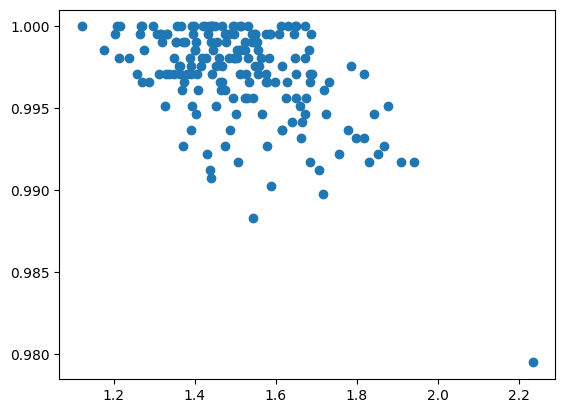

In [33]:
plt.scatter(noise_sd, lsc1_rc)
# plt.scatter(noise_sd, uqn1_width)

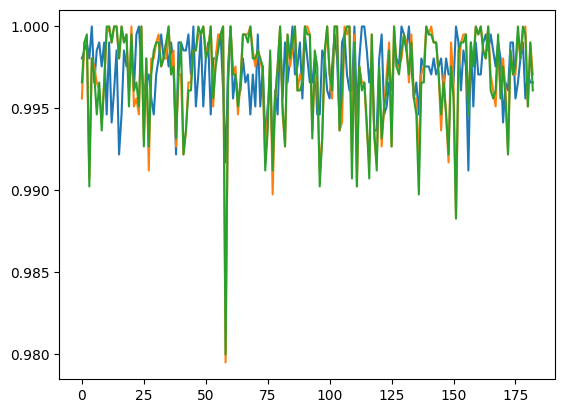

In [34]:
plt.plot(uqn1_rc)
plt.plot(lsc1_rc)
plt.plot(lsc2_rc)

In [51]:
i = 10
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)

lsc1_lower, lsc1_upper = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)

In [70]:
loweri, upperi = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)
yi = ytest_hat[i].reshape(nlat, nlon)

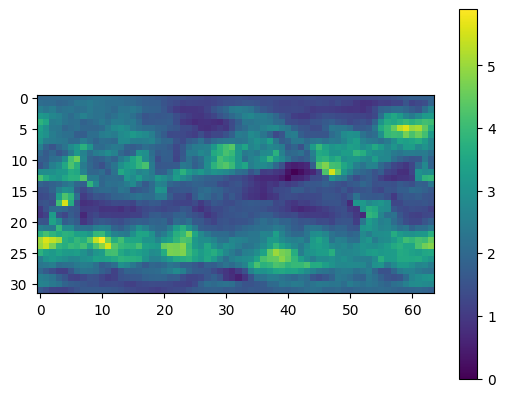

In [71]:
plt.imshow(yi + upperi - loweri)
plt.colorbar()

In [107]:

oracle_rc = []
oracle_width = []

In [108]:
for i in trange(0, 200):
    # Oracle    
    oracle_lower = -jnp.abs(rtest[i])- 1e-7
    oracle_upper = jnp.abs(rtest[i])+ 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

  0%|          | 0/200 [00:00<?, ?it/s]

In [109]:

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

In [110]:
noise_sd = np.std(rtest[:200], axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [111]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.436 & 0.913 \\
1.000 & -0.265 & 2.673 & 0.000 \\
1.000 & -0.265 & 3.002 & 0.000 \\
1.000 & -0.285 & 5.642 & -0.141 \\
0.925 & -0.655 & 1.785 & 0.226 \\
0.935 & -0.662 & 1.791 & 0.217 \\
